In [2]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
df = pd.read_hdf("../datasets/gardening.h5", key="gardening")

In [4]:
model_sent = FastText.load("../models/subreddit_level/fasttext_gardening_senti.bin")

In [5]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [6]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [69]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 
    
    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [70]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [71]:
woman_terms_freq, man_terms_freq

([['she', 'her', 'daughter', 'female', 'girl', 'sister', 'woman'],
  [6901, 2140, 318, 835, 487, 292, 327]],
 [['his', 'he', 'man', 'male', 'son', 'boy', 'brother'],
  [2812, 9963, 1602, 806, 336, 595, 282]])

In [72]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [73]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'her', 'mom', 'wife', 'daughter', 'herself', 'hers', 'grandma', 'funeral', 'elderly']
Top 10 (man) ['he', 'his', 'brother', 'son', 'himself', 'dad', 'husband', 'guy', 'buddy', 'boyfriend']


In [74]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
206,shit,0.000,0.678,0.294
227,hell,0.020,0.918,0.565
257,genocide,0.020,0.878,0.627
189,bloody,0.031,0.910,0.518
195,kidnap,0.032,0.923,0.535


In [75]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
135,murder,0.061,0.942,0.615
99,monstrous,0.094,0.942,0.649
42,revenge,0.230,0.940,0.627
240,monster,0.133,0.935,0.596
317,monstrosity,0.094,0.933,0.611


In [76]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
20,boss,0.310,0.627,0.954
153,mighty,0.855,0.837,0.936
224,audacity,0.760,0.755,0.916
127,supervise,0.698,0.555,0.889
181,god,0.758,0.518,0.886


In [77]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
269,bloody,0.031,0.910,0.518
183,kidnap,0.032,0.923,0.535
202,graveyard,0.041,0.441,0.272
43,divorce,0.042,0.700,0.385
64,cemetery,0.051,0.630,0.417


In [78]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
296,monstrous,0.094,0.942,0.649
217,revenge,0.230,0.940,0.627
116,panic,0.062,0.938,0.400
333,rescue,0.806,0.926,0.850
163,shout,0.229,0.925,0.444


In [79]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
131,boss,0.310,0.627,0.954
208,talented,0.939,0.635,0.938
229,breathtaking,0.936,0.792,0.921
260,audacity,0.760,0.755,0.916
87,supervise,0.698,0.555,0.889


In [80]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.07463607933098049 0.03884872427667812 0.030650107138594798


In [81]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.06996977838099187 0.035782536151402124 0.03230793669015058


In [82]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()
    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))

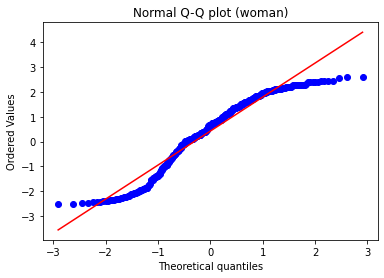

kolmogorv KstestResult(statistic=0.5548554208906687, pvalue=7.397264783928728e-111)


In [83]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

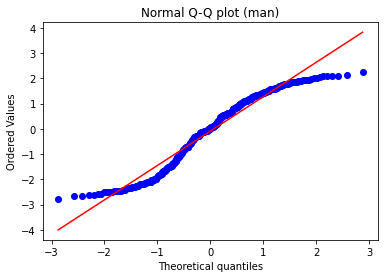

kolmogorv KstestResult(statistic=0.5691650903425977, pvalue=1.4563213491484741e-105)


In [84]:
check_normal_dist(df_NRC_man, "arousal","man")

In [85]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics
   
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("welsh")
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [86]:
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=-2.635653, p=0.009
Different distributions (reject H0)
-0.1963883662019668 Cohens D
381 343
welsh
Statistics=2.971445, p=0.003
Different distributions (reject H0)
0.22135781085098455 Cohens D
381 343
welsh
Statistics=0.541798, p=0.588
Same distribution (fail to reject H0)
381 343


In [87]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5287201166180758 0.5465772594752183 0.5014431486880465
0.5882414698162728 0.5086404199475068 0.5085931758530186
